# GENERATING FACES WITH VARIATIONAL AUTOENCODER

Gustaw Andrzejewski, 175207, Inżynieria biomedyczna - grupa 2

# Importing neccessery dependencies

In [1]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.8 MB/s eta 0:00:00


In [2]:
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
from PIL import Image
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchvision.transforms import AutoAugment
from tqdm import tqdm

# Loading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/MyDrive/UG/lfw-deepfunneled'

In [5]:
# selecting 5000 images as face cropping would take a lot time for more for full dataset
dataset = []
for path in glob.iglob(os.path.join(DATA_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 20 )
dataset = dataset.sample(5000).reset_index(drop=True)
dataset

,person,path
0,Martin_Gecht,/content/drive/MyDrive/UG/lfw-deepfunneled/Mar...
1,Jayson_Williams,/content/drive/MyDrive/UG/lfw-deepfunneled/Jay...
2,Michelle_Yeoh,/content/drive/MyDrive/UG/lfw-deepfunneled/Mic...
3,Patrick_Leahy,/content/drive/MyDrive/UG/lfw-deepfunneled/Pat...
4,Ellen_Barkin,/content/drive/MyDrive/UG/lfw-deepfunneled/Ell...
...,...,...
4995,Alimzhan_Tokhtakhounov,/content/drive/MyDrive/UG/lfw-deepfunneled/Ali...
4996,Dino_Risi,/content/drive/MyDrive/UG/lfw-deepfunneled/Din...
4997,Kurt_Thomas,/content/drive/MyDrive/UG/lfw-deepfunneled/Kur...
4998,Curtis_Strange,/content/drive/MyDrive/UG/lfw-deepfunneled/Cur...


# Plotting images from the dataset

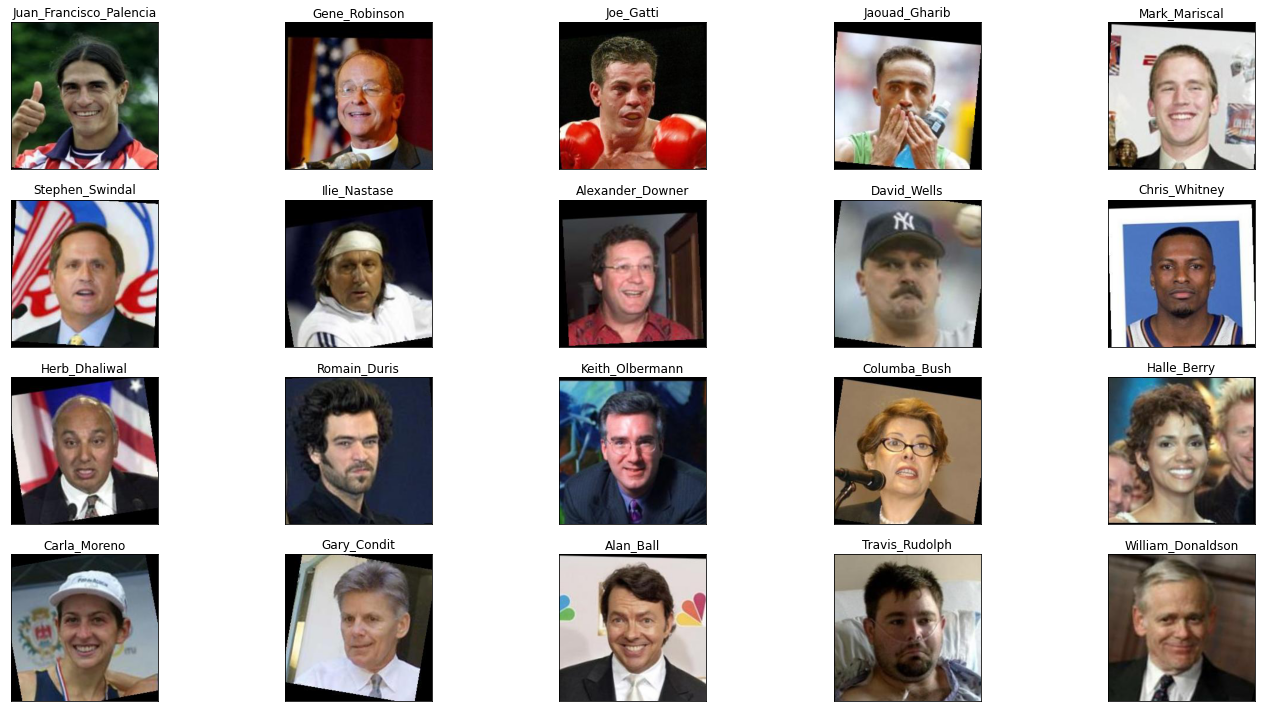

In [6]:
plt.figure(figsize=(20,10))
for i in range(20):
    idx = random.randint(0, len(dataset))
    img = plt.imread(dataset.path.iloc[idx])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(dataset.person.iloc[idx])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Cropping the faces from the images using MTCNN face detector

In [7]:
#cropping only faces and converting them to grayscale
def get_face_grayscale(img_path, face_detector):
  try:
    img = cv2.imread(img_path)
    boxes = face_detector.detect(img)
    x1, y1, x2, y2 = np.round(boxes[0][0]).astype(int)
    face = img[y1:y2, x1:x2]
    face_gray =  cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    
    return face_gray
  except:
    return None
# returning None for the sake of eliminating images where face wasn't detected

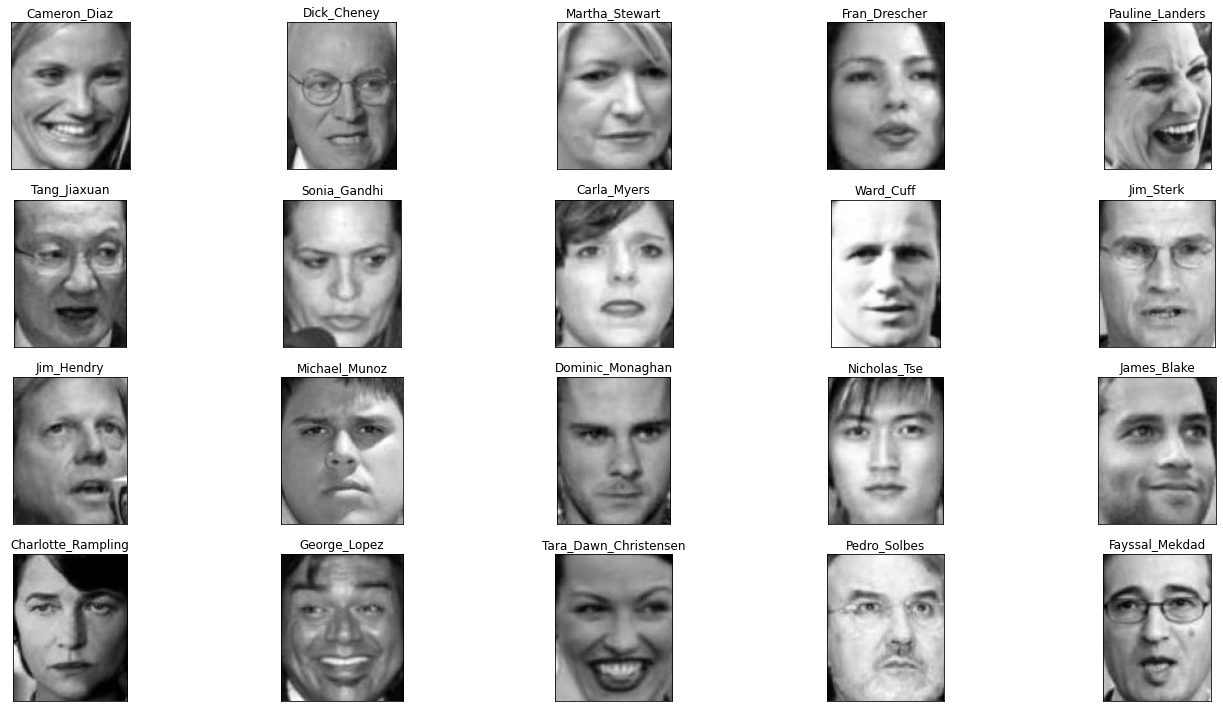

In [8]:
# example of cropping faces
mtcnn = MTCNN()

plt.figure(figsize=(20,10))
i = 0
while i <20:
    idx = random.randint(0, len(dataset))
    face_gray = get_face_grayscale(dataset.path.iloc[idx], mtcnn)
    if face_gray is None:
      break
    else:
      plt.subplot(4, 5, i+1)
      plt.imshow(face_gray, cmap='gray')
      plt.title(dataset.person.iloc[idx])
      plt.xticks([])
      plt.yticks([])
      i += 1
plt.tight_layout()
plt.show()

In [11]:
def get_faces_training_data(dataframe, image_path_column, face_detector):
  dataframe['images'] = None
  for i in tqdm(range(len(dataframe))):
    dataframe['images'][i] = get_face_grayscale(dataframe[image_path_column][i], face_detector)

  return dataframe

In [12]:
mtcnn = MTCNN()
dataset = get_faces_training_data(dataset, 'path', mtcnn)
dataset.head()

100%|██████████| 5000/5000 [59:18<00:00,  1.41it/s]


,person,path,images
0,Martin_Gecht,/content/drive/MyDrive/UG/lfw-deepfunneled/Mar...,"[[117, 128, 151, 163, 159, 149, 145, 152, 158,..."
1,Jayson_Williams,/content/drive/MyDrive/UG/lfw-deepfunneled/Jay...,"[[88, 88, 89, 89, 93, 93, 91, 82, 66, 54, 55, ..."
2,Michelle_Yeoh,/content/drive/MyDrive/UG/lfw-deepfunneled/Mic...,"[[25, 33, 33, 33, 34, 35, 37, 38, 39, 36, 41, ..."
3,Patrick_Leahy,/content/drive/MyDrive/UG/lfw-deepfunneled/Pat...,"[[150, 148, 147, 146, 148, 151, 153, 154, 154,..."
4,Ellen_Barkin,/content/drive/MyDrive/UG/lfw-deepfunneled/Ell...,"[[64, 70, 77, 78, 76, 78, 88, 98, 111, 113, 10..."


In [13]:
#dropping rows were face wasn't detected
dataset = dataset.dropna().reset_index(drop=True)
print(dataset.isna().value_counts())
dataset

person  path   images
False   False  False     4809
dtype: int64


,person,path,images
0,Martin_Gecht,/content/drive/MyDrive/UG/lfw-deepfunneled/Mar...,"[[117, 128, 151, 163, 159, 149, 145, 152, 158,..."
1,Jayson_Williams,/content/drive/MyDrive/UG/lfw-deepfunneled/Jay...,"[[88, 88, 89, 89, 93, 93, 91, 82, 66, 54, 55, ..."
2,Michelle_Yeoh,/content/drive/MyDrive/UG/lfw-deepfunneled/Mic...,"[[25, 33, 33, 33, 34, 35, 37, 38, 39, 36, 41, ..."
3,Patrick_Leahy,/content/drive/MyDrive/UG/lfw-deepfunneled/Pat...,"[[150, 148, 147, 146, 148, 151, 153, 154, 154,..."
4,Ellen_Barkin,/content/drive/MyDrive/UG/lfw-deepfunneled/Ell...,"[[64, 70, 77, 78, 76, 78, 88, 98, 111, 113, 10..."
...,...,...,...
4804,Alimzhan_Tokhtakhounov,/content/drive/MyDrive/UG/lfw-deepfunneled/Ali...,"[[24, 27, 28, 26, 24, 24, 22, 21, 26, 36, 43, ..."
4805,Dino_Risi,/content/drive/MyDrive/UG/lfw-deepfunneled/Din...,"[[168, 160, 151, 142, 134, 124, 115, 110, 116,..."
4806,Kurt_Thomas,/content/drive/MyDrive/UG/lfw-deepfunneled/Kur...,"[[61, 61, 62, 62, 62, 62, 63, 63, 66, 64, 59, ..."
4807,Curtis_Strange,/content/drive/MyDrive/UG/lfw-deepfunneled/Cur...,"[[205, 203, 207, 216, 212, 213, 214, 217, 220,..."


# Preparing training data

In [14]:
def get_training_data(dataframe, image_column):
  training_data = dataframe[image_column].apply(lambda x: cv2.resize(x, (64,64)))
  training_data = np.stack(training_data.values).astype('uint8')
  training_data = training_data / 255
  training_data = torch.from_numpy(training_data)
  training_data = training_data.view(-1, 1, 64, 64)

  return training_data

In [15]:
def split_training_data(training_data):
  X_train, X_test, y_train, y_test = train_test_split(training_data,training_data, train_size=0.8)

  X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.5)

  return X_train, X_test, X_val, y_train, y_test, y_val

In [16]:
training_data = get_training_data(dataset, 'images')
X_train, X_test, X_val, y_train, y_test, y_val = split_training_data(training_data)

# Creating the model

In [17]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :64, :64]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 256, stride=(1, 1), kernel_size=(3, 3), bias=False, padding=1),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.Conv2d(256, 256, stride=(2, 2), kernel_size=(5, 5), bias=False, padding=2),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.Conv2d(256, 128, stride=(2, 2), kernel_size=(5, 5), bias=False, padding=2),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.Conv2d(128, 64, stride=(2, 2), kernel_size=(3, 3), bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), bias=False, padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 512)
        self.z_log_var = torch.nn.Linear(4096, 512)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(512, 4096),
                Reshape(-1, 64, 8, 8),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.ConvTranspose2d(64, 128, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.ConvTranspose2d(128, 256, stride=(2, 2), kernel_size=(5, 5), padding=2),
                nn.BatchNorm2d(256),        
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.ConvTranspose2d(256, 128, stride=(2, 2), kernel_size=(5, 5), padding=1),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.ConvTranspose2d(128, 256, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.ConvTranspose2d(256, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),
                nn.Sigmoid()
                )
        
        self.augmentation = AutoAugment()


    def encoding_fn(self, x):
        x = self.augmentation(x)
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

# loss function in form of reconstruction loss (here MSE) - Kullback Leibler Divergence
def loss_vae_fn(x, recon_x, z_mean, z_log_var):    
    R_Loss = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return R_Loss + KLD

In [18]:
device = torch.device('cuda:0')
model = VAE().to(device)

summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 64, 64]           2,304
       BatchNorm2d-2          [-1, 256, 64, 64]             512
         LeakyReLU-3          [-1, 256, 64, 64]               0
           Dropout-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]       1,638,400
       BatchNorm2d-6          [-1, 256, 32, 32]             512
         LeakyReLU-7          [-1, 256, 32, 32]               0
           Dropout-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 128, 16, 16]         819,200
      BatchNorm2d-10          [-1, 128, 16, 16]             256
        LeakyReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          73,728
      BatchNorm2d-14             [-1, 6

# Training loop

In [19]:
model = model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

EPOCHS = 500
BATCH_SIZE = 128
N_EPOCHS = 25
BEST_LOSS = 500
TRAINING_LOSS = {}
VALIDATION_LOSS = {}
PATIENCE = 50
early_stopping_counter = 0

for epoch in tqdm(range(EPOCHS)):
    # Initializing the training loss for this epoch
    train_loss = 0.0
    
    # Setting the model to training mode
    model.train()
    
    # Iterating through the training data in batches
    for i in range(0, len(X_train), BATCH_SIZE):
        # Get the current batch of data
        x = X_train[i:i+BATCH_SIZE]
        
        # Moving the data to the device the model is on
        # x = x.to(device)
        x = x.float().to(device)
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass through the model
        encoded, z_mean, z_log_var, decoded = model(x)
        
        # Computing loss
        loss = loss_vae_fn(x, decoded, z_mean, z_log_var)
        
        # Backpropagating loss
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        # Accumulating training loss
        train_loss += loss.item()
    
    # Computing average training loss for this epoch
    train_loss = train_loss / len(X_train)
    TRAINING_LOSS.update({epoch: train_loss})

    
    # Initializing validation loss for this epoch
    val_loss = 0.0
    
    # Setting the model to evaluation mode
    model.eval()
    
    # Iterating through the validation data
    for i in range(0, len(X_test), BATCH_SIZE):
        x = X_test[i:i+BATCH_SIZE]
        
        # Moving the data to the device model is on
        x = x.float().to(device)
        
        # Forward pass through the model
        encoded, z_mean, z_log_var, decoded = model(x)
        
        # Computing loss
        loss = loss_vae_fn(x, decoded, z_mean, z_log_var)
        
        # Accumulating validation loss
        val_loss += loss.item()
    
    # Computing average validation loss for this epoch
    val_loss = val_loss / len(X_test)
    VALIDATION_LOSS.update({epoch: val_loss})

    # saving model every n epochs
    if epoch % N_EPOCHS == 0 and epoch > 0:
        torch.save(model.state_dict(), f'model_epoch{epoch}.pt')

    # saving the best model based on lowest value for validation loss
    if val_loss < BEST_LOSS:
        BEST_LOSS = val_loss
        torch.save(model.state_dict(), 'best_model2.pt')

        # Reseting the counter
        early_stopping_counter = 0
    else:
        # Incrementing the counter
        early_stopping_counter += 1    
    
    # Printing the current training and validation losses
    print(f'Epoch {epoch+1}/{EPOCHS} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # Checking if the patience is met
    if early_stopping_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch} due to no improvement")
        break

  0%|          | 1/500 [00:21<3:01:00, 21.76s/it]

Epoch 1/500 - Training Loss: 384.9284 - Validation Loss: 185.1219


  0%|          | 2/500 [00:43<2:58:32, 21.51s/it]

Epoch 2/500 - Training Loss: 181.4218 - Validation Loss: 156.0284


  1%|          | 3/500 [01:04<2:58:21, 21.53s/it]

Epoch 3/500 - Training Loss: 163.8586 - Validation Loss: 151.8381


  1%|          | 4/500 [01:26<2:58:30, 21.59s/it]

Epoch 4/500 - Training Loss: 161.4392 - Validation Loss: 142.1695


  1%|          | 5/500 [01:48<2:59:01, 21.70s/it]

Epoch 5/500 - Training Loss: 155.7350 - Validation Loss: 147.4933


  1%|          | 6/500 [02:10<3:00:00, 21.86s/it]

Epoch 6/500 - Training Loss: 151.2386 - Validation Loss: 146.1454


  1%|▏         | 7/500 [02:32<3:00:19, 21.95s/it]

Epoch 7/500 - Training Loss: 146.2779 - Validation Loss: 133.4383


  2%|▏         | 8/500 [02:54<3:00:25, 22.00s/it]

Epoch 8/500 - Training Loss: 141.5559 - Validation Loss: 125.4079


  2%|▏         | 9/500 [03:16<3:00:40, 22.08s/it]

Epoch 9/500 - Training Loss: 132.2631 - Validation Loss: 110.3667


  2%|▏         | 10/500 [03:39<3:01:05, 22.17s/it]

Epoch 10/500 - Training Loss: 111.8450 - Validation Loss: 94.0603


  2%|▏         | 11/500 [04:02<3:02:07, 22.35s/it]

Epoch 11/500 - Training Loss: 100.0765 - Validation Loss: 87.6144


  2%|▏         | 12/500 [04:24<3:02:21, 22.42s/it]

Epoch 12/500 - Training Loss: 94.5427 - Validation Loss: 85.6584


  3%|▎         | 13/500 [04:47<3:02:09, 22.44s/it]

Epoch 13/500 - Training Loss: 91.2707 - Validation Loss: 81.5910


  3%|▎         | 14/500 [05:09<3:01:55, 22.46s/it]

Epoch 14/500 - Training Loss: 89.7759 - Validation Loss: 82.8569


  3%|▎         | 15/500 [05:32<3:01:46, 22.49s/it]

Epoch 15/500 - Training Loss: 86.3332 - Validation Loss: 78.7155


  3%|▎         | 16/500 [05:54<3:01:47, 22.54s/it]

Epoch 16/500 - Training Loss: 84.0812 - Validation Loss: 77.0367


  3%|▎         | 17/500 [06:17<3:01:18, 22.52s/it]

Epoch 17/500 - Training Loss: 82.7707 - Validation Loss: 83.7264


  4%|▎         | 18/500 [06:39<3:00:50, 22.51s/it]

Epoch 18/500 - Training Loss: 82.3492 - Validation Loss: 78.5952


  4%|▍         | 19/500 [07:02<3:00:31, 22.52s/it]

Epoch 19/500 - Training Loss: 81.1348 - Validation Loss: 76.3799


  4%|▍         | 20/500 [07:24<3:00:14, 22.53s/it]

Epoch 20/500 - Training Loss: 79.8844 - Validation Loss: 75.1702


  4%|▍         | 21/500 [07:47<3:00:09, 22.57s/it]

Epoch 21/500 - Training Loss: 78.5312 - Validation Loss: 73.2490


  4%|▍         | 22/500 [08:10<2:59:54, 22.58s/it]

Epoch 22/500 - Training Loss: 78.0809 - Validation Loss: 73.1392


  5%|▍         | 23/500 [08:32<2:59:25, 22.57s/it]

Epoch 23/500 - Training Loss: 76.3292 - Validation Loss: 75.5577


  5%|▍         | 24/500 [08:55<2:59:12, 22.59s/it]

Epoch 24/500 - Training Loss: 74.9313 - Validation Loss: 72.1543


  5%|▌         | 25/500 [09:17<2:58:55, 22.60s/it]

Epoch 25/500 - Training Loss: 74.1842 - Validation Loss: 71.1567


  5%|▌         | 26/500 [09:40<2:58:38, 22.61s/it]

Epoch 26/500 - Training Loss: 72.9208 - Validation Loss: 67.9874


  5%|▌         | 27/500 [10:03<2:58:13, 22.61s/it]

Epoch 27/500 - Training Loss: 73.3452 - Validation Loss: 66.5447


  6%|▌         | 28/500 [10:25<2:57:46, 22.60s/it]

Epoch 28/500 - Training Loss: 71.2657 - Validation Loss: 65.9317


  6%|▌         | 29/500 [10:48<2:57:10, 22.57s/it]

Epoch 29/500 - Training Loss: 72.8503 - Validation Loss: 69.6445


  6%|▌         | 30/500 [11:10<2:56:39, 22.55s/it]

Epoch 30/500 - Training Loss: 71.4636 - Validation Loss: 66.0040


  6%|▌         | 31/500 [11:33<2:56:28, 22.58s/it]

Epoch 31/500 - Training Loss: 69.6509 - Validation Loss: 65.0263


  6%|▋         | 32/500 [11:55<2:56:03, 22.57s/it]

Epoch 32/500 - Training Loss: 68.6018 - Validation Loss: 65.7448


  7%|▋         | 33/500 [12:18<2:55:50, 22.59s/it]

Epoch 33/500 - Training Loss: 67.3116 - Validation Loss: 63.0117


  7%|▋         | 34/500 [12:41<2:55:32, 22.60s/it]

Epoch 34/500 - Training Loss: 66.4664 - Validation Loss: 62.1737


  7%|▋         | 35/500 [13:03<2:54:59, 22.58s/it]

Epoch 35/500 - Training Loss: 66.3553 - Validation Loss: 64.3331


  7%|▋         | 36/500 [13:26<2:54:30, 22.57s/it]

Epoch 36/500 - Training Loss: 66.8066 - Validation Loss: 63.0947


  7%|▋         | 37/500 [13:48<2:54:03, 22.56s/it]

Epoch 37/500 - Training Loss: 65.5131 - Validation Loss: 63.6626


  8%|▊         | 38/500 [14:11<2:53:49, 22.58s/it]

Epoch 38/500 - Training Loss: 64.8308 - Validation Loss: 61.5736


  8%|▊         | 39/500 [14:34<2:53:33, 22.59s/it]

Epoch 39/500 - Training Loss: 64.5852 - Validation Loss: 60.4697


  8%|▊         | 40/500 [14:56<2:53:02, 22.57s/it]

Epoch 40/500 - Training Loss: 63.9077 - Validation Loss: 61.2730


  8%|▊         | 41/500 [15:19<2:52:44, 22.58s/it]

Epoch 41/500 - Training Loss: 64.4985 - Validation Loss: 59.6610


  8%|▊         | 42/500 [15:41<2:52:13, 22.56s/it]

Epoch 42/500 - Training Loss: 62.9977 - Validation Loss: 60.1770


  9%|▊         | 43/500 [16:04<2:51:47, 22.56s/it]

Epoch 43/500 - Training Loss: 62.3878 - Validation Loss: 64.8805


  9%|▉         | 44/500 [16:26<2:51:32, 22.57s/it]

Epoch 44/500 - Training Loss: 62.1747 - Validation Loss: 58.3151


  9%|▉         | 45/500 [16:49<2:51:01, 22.55s/it]

Epoch 45/500 - Training Loss: 61.4774 - Validation Loss: 58.6198


  9%|▉         | 46/500 [17:11<2:50:34, 22.54s/it]

Epoch 46/500 - Training Loss: 61.2125 - Validation Loss: 68.2932


  9%|▉         | 47/500 [17:34<2:50:17, 22.56s/it]

Epoch 47/500 - Training Loss: 61.7952 - Validation Loss: 57.0171


 10%|▉         | 48/500 [17:56<2:49:49, 22.54s/it]

Epoch 48/500 - Training Loss: 61.2845 - Validation Loss: 59.9972


 10%|▉         | 49/500 [18:19<2:49:23, 22.54s/it]

Epoch 49/500 - Training Loss: 61.4042 - Validation Loss: 90.1311


 10%|█         | 50/500 [18:42<2:49:07, 22.55s/it]

Epoch 50/500 - Training Loss: 62.2640 - Validation Loss: 56.8378


 10%|█         | 51/500 [19:04<2:48:47, 22.56s/it]

Epoch 51/500 - Training Loss: 62.0500 - Validation Loss: 58.0355


 10%|█         | 52/500 [19:27<2:48:08, 22.52s/it]

Epoch 52/500 - Training Loss: 60.8523 - Validation Loss: 59.9293


 11%|█         | 53/500 [19:49<2:47:26, 22.47s/it]

Epoch 53/500 - Training Loss: 60.6564 - Validation Loss: 60.0478


 11%|█         | 54/500 [20:11<2:46:50, 22.44s/it]

Epoch 54/500 - Training Loss: 62.5067 - Validation Loss: 59.1893


 11%|█         | 55/500 [20:34<2:46:20, 22.43s/it]

Epoch 55/500 - Training Loss: 60.5325 - Validation Loss: 58.0273


 11%|█         | 56/500 [20:56<2:45:54, 22.42s/it]

Epoch 56/500 - Training Loss: 60.0838 - Validation Loss: 58.9813


 11%|█▏        | 57/500 [21:19<2:45:30, 22.42s/it]

Epoch 57/500 - Training Loss: 59.9886 - Validation Loss: 58.0641


 12%|█▏        | 58/500 [21:41<2:45:06, 22.41s/it]

Epoch 58/500 - Training Loss: 59.7606 - Validation Loss: 58.0031


 12%|█▏        | 59/500 [22:03<2:44:41, 22.41s/it]

Epoch 59/500 - Training Loss: 59.7676 - Validation Loss: 60.6208


 12%|█▏        | 60/500 [22:26<2:44:14, 22.40s/it]

Epoch 60/500 - Training Loss: 59.4622 - Validation Loss: 57.6825


 12%|█▏        | 61/500 [22:48<2:43:46, 22.38s/it]

Epoch 61/500 - Training Loss: 59.3283 - Validation Loss: 58.1834


 12%|█▏        | 62/500 [23:11<2:43:37, 22.41s/it]

Epoch 62/500 - Training Loss: 59.3657 - Validation Loss: 56.4102


 13%|█▎        | 63/500 [23:33<2:43:15, 22.42s/it]

Epoch 63/500 - Training Loss: 58.9759 - Validation Loss: 56.9507


 13%|█▎        | 64/500 [23:55<2:42:56, 22.42s/it]

Epoch 64/500 - Training Loss: 58.9930 - Validation Loss: 61.9661


 13%|█▎        | 65/500 [24:18<2:42:33, 22.42s/it]

Epoch 65/500 - Training Loss: 59.2209 - Validation Loss: 57.2686


 13%|█▎        | 66/500 [24:40<2:42:07, 22.41s/it]

Epoch 66/500 - Training Loss: 59.0403 - Validation Loss: 64.8454


 13%|█▎        | 67/500 [25:03<2:41:40, 22.40s/it]

Epoch 67/500 - Training Loss: 59.8613 - Validation Loss: 58.3275


 14%|█▎        | 68/500 [25:25<2:41:14, 22.40s/it]

Epoch 68/500 - Training Loss: 58.9736 - Validation Loss: 57.2216


 14%|█▍        | 69/500 [25:47<2:41:03, 22.42s/it]

Epoch 69/500 - Training Loss: 58.7260 - Validation Loss: 56.1280


 14%|█▍        | 70/500 [26:10<2:40:39, 22.42s/it]

Epoch 70/500 - Training Loss: 58.2133 - Validation Loss: 56.3499


 14%|█▍        | 71/500 [26:32<2:40:29, 22.45s/it]

Epoch 71/500 - Training Loss: 58.2657 - Validation Loss: 56.1191


 14%|█▍        | 72/500 [26:55<2:40:03, 22.44s/it]

Epoch 72/500 - Training Loss: 58.8225 - Validation Loss: 56.5910


 15%|█▍        | 73/500 [27:17<2:39:39, 22.43s/it]

Epoch 73/500 - Training Loss: 58.0528 - Validation Loss: 57.0120


 15%|█▍        | 74/500 [27:40<2:39:26, 22.46s/it]

Epoch 74/500 - Training Loss: 57.9789 - Validation Loss: 55.7510


 15%|█▌        | 75/500 [28:02<2:38:56, 22.44s/it]

Epoch 75/500 - Training Loss: 58.1947 - Validation Loss: 57.0287


 15%|█▌        | 76/500 [28:25<2:38:35, 22.44s/it]

Epoch 76/500 - Training Loss: 59.2800 - Validation Loss: 58.5106


 15%|█▌        | 77/500 [28:47<2:38:03, 22.42s/it]

Epoch 77/500 - Training Loss: 59.8621 - Validation Loss: 57.3798


 16%|█▌        | 78/500 [29:09<2:37:35, 22.41s/it]

Epoch 78/500 - Training Loss: 58.0186 - Validation Loss: 60.1580


 16%|█▌        | 79/500 [29:32<2:37:09, 22.40s/it]

Epoch 79/500 - Training Loss: 58.1056 - Validation Loss: 60.3163


 16%|█▌        | 80/500 [29:54<2:36:43, 22.39s/it]

Epoch 80/500 - Training Loss: 58.1791 - Validation Loss: 56.7301


 16%|█▌        | 81/500 [30:17<2:36:29, 22.41s/it]

Epoch 81/500 - Training Loss: 57.7236 - Validation Loss: 55.6275


 16%|█▋        | 82/500 [30:39<2:36:00, 22.39s/it]

Epoch 82/500 - Training Loss: 57.2514 - Validation Loss: 55.7546


 17%|█▋        | 83/500 [31:01<2:35:44, 22.41s/it]

Epoch 83/500 - Training Loss: 57.1317 - Validation Loss: 54.8458


 17%|█▋        | 84/500 [31:24<2:35:14, 22.39s/it]

Epoch 84/500 - Training Loss: 56.9165 - Validation Loss: 56.2929


 17%|█▋        | 85/500 [31:46<2:34:48, 22.38s/it]

Epoch 85/500 - Training Loss: 56.8559 - Validation Loss: 59.6849


 17%|█▋        | 86/500 [32:08<2:34:25, 22.38s/it]

Epoch 86/500 - Training Loss: 56.8600 - Validation Loss: 55.6746


 17%|█▋        | 87/500 [32:31<2:34:04, 22.38s/it]

Epoch 87/500 - Training Loss: 56.7095 - Validation Loss: 55.9794


 18%|█▊        | 88/500 [32:53<2:33:45, 22.39s/it]

Epoch 88/500 - Training Loss: 56.7970 - Validation Loss: 56.6383


 18%|█▊        | 89/500 [33:16<2:33:23, 22.39s/it]

Epoch 89/500 - Training Loss: 56.7392 - Validation Loss: 56.0992


 18%|█▊        | 90/500 [33:38<2:32:59, 22.39s/it]

Epoch 90/500 - Training Loss: 56.9816 - Validation Loss: 54.8582


 18%|█▊        | 91/500 [34:00<2:32:35, 22.38s/it]

Epoch 91/500 - Training Loss: 57.2050 - Validation Loss: 55.0919


 18%|█▊        | 92/500 [34:23<2:32:24, 22.41s/it]

Epoch 92/500 - Training Loss: 56.5327 - Validation Loss: 54.6047


 19%|█▊        | 93/500 [34:45<2:31:56, 22.40s/it]

Epoch 93/500 - Training Loss: 56.5188 - Validation Loss: 56.2581


 19%|█▉        | 94/500 [35:08<2:31:30, 22.39s/it]

Epoch 94/500 - Training Loss: 56.2908 - Validation Loss: 55.7802


 19%|█▉        | 95/500 [35:30<2:31:08, 22.39s/it]

Epoch 95/500 - Training Loss: 56.2927 - Validation Loss: 55.1057


 19%|█▉        | 96/500 [35:52<2:30:56, 22.42s/it]

Epoch 96/500 - Training Loss: 55.9933 - Validation Loss: 54.3116


 19%|█▉        | 97/500 [36:15<2:30:28, 22.40s/it]

Epoch 97/500 - Training Loss: 55.8909 - Validation Loss: 56.4245


 20%|█▉        | 98/500 [36:37<2:30:07, 22.41s/it]

Epoch 98/500 - Training Loss: 56.1165 - Validation Loss: 63.4033


 20%|█▉        | 99/500 [37:00<2:29:44, 22.41s/it]

Epoch 99/500 - Training Loss: 59.3092 - Validation Loss: 57.2942


 20%|██        | 100/500 [37:22<2:29:21, 22.40s/it]

Epoch 100/500 - Training Loss: 57.1905 - Validation Loss: 55.9902


 20%|██        | 101/500 [37:45<2:29:05, 22.42s/it]

Epoch 101/500 - Training Loss: 56.7314 - Validation Loss: 55.4481


 20%|██        | 102/500 [38:07<2:28:38, 22.41s/it]

Epoch 102/500 - Training Loss: 56.1122 - Validation Loss: 54.7955


 21%|██        | 103/500 [38:29<2:28:12, 22.40s/it]

Epoch 103/500 - Training Loss: 55.9266 - Validation Loss: 55.6295


 21%|██        | 104/500 [38:52<2:27:48, 22.39s/it]

Epoch 104/500 - Training Loss: 56.0738 - Validation Loss: 54.4275


 21%|██        | 105/500 [39:14<2:27:24, 22.39s/it]

Epoch 105/500 - Training Loss: 55.9067 - Validation Loss: 58.3407


 21%|██        | 106/500 [39:36<2:27:03, 22.40s/it]

Epoch 106/500 - Training Loss: 55.7801 - Validation Loss: 54.7452


 21%|██▏       | 107/500 [39:59<2:26:41, 22.40s/it]

Epoch 107/500 - Training Loss: 55.5352 - Validation Loss: 56.1319


 22%|██▏       | 108/500 [40:21<2:26:20, 22.40s/it]

Epoch 108/500 - Training Loss: 55.6619 - Validation Loss: 54.8017


 22%|██▏       | 109/500 [40:44<2:25:58, 22.40s/it]

Epoch 109/500 - Training Loss: 55.3705 - Validation Loss: 54.4999


 22%|██▏       | 110/500 [41:06<2:25:48, 22.43s/it]

Epoch 110/500 - Training Loss: 55.0325 - Validation Loss: 54.0968


 22%|██▏       | 111/500 [41:29<2:25:22, 22.42s/it]

Epoch 111/500 - Training Loss: 55.2673 - Validation Loss: 54.4344


 22%|██▏       | 112/500 [41:51<2:24:56, 22.41s/it]

Epoch 112/500 - Training Loss: 55.1713 - Validation Loss: 54.6900


 23%|██▎       | 113/500 [42:13<2:24:34, 22.41s/it]

Epoch 113/500 - Training Loss: 55.0550 - Validation Loss: 57.0944


 23%|██▎       | 114/500 [42:36<2:24:10, 22.41s/it]

Epoch 114/500 - Training Loss: 55.0766 - Validation Loss: 57.8588


 23%|██▎       | 115/500 [42:58<2:23:47, 22.41s/it]

Epoch 115/500 - Training Loss: 55.4631 - Validation Loss: 61.7390


 23%|██▎       | 116/500 [43:21<2:23:24, 22.41s/it]

Epoch 116/500 - Training Loss: 55.4164 - Validation Loss: 54.7882


 23%|██▎       | 117/500 [43:43<2:23:01, 22.41s/it]

Epoch 117/500 - Training Loss: 54.9989 - Validation Loss: 54.6317


 24%|██▎       | 118/500 [44:05<2:22:37, 22.40s/it]

Epoch 118/500 - Training Loss: 54.9189 - Validation Loss: 54.9945


 24%|██▍       | 119/500 [44:28<2:22:13, 22.40s/it]

Epoch 119/500 - Training Loss: 54.6332 - Validation Loss: 54.1486


 24%|██▍       | 120/500 [44:50<2:22:02, 22.43s/it]

Epoch 120/500 - Training Loss: 54.6182 - Validation Loss: 53.7882


 24%|██▍       | 121/500 [45:13<2:21:35, 22.42s/it]

Epoch 121/500 - Training Loss: 54.4299 - Validation Loss: 54.3079


 24%|██▍       | 122/500 [45:35<2:21:09, 22.41s/it]

Epoch 122/500 - Training Loss: 54.6361 - Validation Loss: 55.4029


 25%|██▍       | 123/500 [45:57<2:20:43, 22.40s/it]

Epoch 123/500 - Training Loss: 54.6492 - Validation Loss: 59.9258


 25%|██▍       | 124/500 [46:20<2:20:19, 22.39s/it]

Epoch 124/500 - Training Loss: 54.8693 - Validation Loss: 55.9323


 25%|██▌       | 125/500 [46:42<2:19:55, 22.39s/it]

Epoch 125/500 - Training Loss: 54.6447 - Validation Loss: 54.7620


 25%|██▌       | 126/500 [47:05<2:19:41, 22.41s/it]

Epoch 126/500 - Training Loss: 54.3846 - Validation Loss: 73.9008


 25%|██▌       | 127/500 [47:27<2:19:26, 22.43s/it]

Epoch 127/500 - Training Loss: 55.2049 - Validation Loss: 53.1905


 26%|██▌       | 128/500 [47:49<2:18:59, 22.42s/it]

Epoch 128/500 - Training Loss: 54.3964 - Validation Loss: 53.8358


 26%|██▌       | 129/500 [48:12<2:18:34, 22.41s/it]

Epoch 129/500 - Training Loss: 54.2458 - Validation Loss: 53.8093


 26%|██▌       | 130/500 [48:34<2:18:09, 22.40s/it]

Epoch 130/500 - Training Loss: 54.1572 - Validation Loss: 53.4410


 26%|██▌       | 131/500 [48:57<2:17:43, 22.39s/it]

Epoch 131/500 - Training Loss: 54.0624 - Validation Loss: 53.4348


 26%|██▋       | 132/500 [49:19<2:17:29, 22.42s/it]

Epoch 132/500 - Training Loss: 54.2641 - Validation Loss: 52.9681


 27%|██▋       | 133/500 [49:41<2:17:02, 22.40s/it]

Epoch 133/500 - Training Loss: 54.1896 - Validation Loss: 53.7607


 27%|██▋       | 134/500 [50:04<2:16:47, 22.43s/it]

Epoch 134/500 - Training Loss: 53.8778 - Validation Loss: 52.7037


 27%|██▋       | 135/500 [50:26<2:16:20, 22.41s/it]

Epoch 135/500 - Training Loss: 53.9196 - Validation Loss: 54.2633


 27%|██▋       | 136/500 [50:49<2:15:54, 22.40s/it]

Epoch 136/500 - Training Loss: 53.5739 - Validation Loss: 56.7678


 27%|██▋       | 137/500 [51:11<2:15:30, 22.40s/it]

Epoch 137/500 - Training Loss: 54.0239 - Validation Loss: 53.8321


 28%|██▊       | 138/500 [51:34<2:15:07, 22.40s/it]

Epoch 138/500 - Training Loss: 54.3475 - Validation Loss: 55.2641


 28%|██▊       | 139/500 [51:56<2:14:44, 22.39s/it]

Epoch 139/500 - Training Loss: 53.9069 - Validation Loss: 53.9370


 28%|██▊       | 140/500 [52:18<2:14:22, 22.40s/it]

Epoch 140/500 - Training Loss: 53.8431 - Validation Loss: 53.1855


 28%|██▊       | 141/500 [52:41<2:13:59, 22.40s/it]

Epoch 141/500 - Training Loss: 53.5509 - Validation Loss: 53.3544


 28%|██▊       | 142/500 [53:03<2:13:37, 22.40s/it]

Epoch 142/500 - Training Loss: 53.8428 - Validation Loss: 53.8414


 29%|██▊       | 143/500 [53:25<2:13:16, 22.40s/it]

Epoch 143/500 - Training Loss: 53.5045 - Validation Loss: 52.9170


 29%|██▉       | 144/500 [53:48<2:12:55, 22.40s/it]

Epoch 144/500 - Training Loss: 53.4454 - Validation Loss: 56.1520


 29%|██▉       | 145/500 [54:10<2:12:29, 22.39s/it]

Epoch 145/500 - Training Loss: 53.3655 - Validation Loss: 53.7395


 29%|██▉       | 146/500 [54:33<2:12:05, 22.39s/it]

Epoch 146/500 - Training Loss: 53.4614 - Validation Loss: 54.9650


 29%|██▉       | 147/500 [54:55<2:11:46, 22.40s/it]

Epoch 147/500 - Training Loss: 53.3490 - Validation Loss: 54.2793


 30%|██▉       | 148/500 [55:18<2:11:28, 22.41s/it]

Epoch 148/500 - Training Loss: 53.4571 - Validation Loss: 55.7886


 30%|██▉       | 149/500 [55:40<2:11:05, 22.41s/it]

Epoch 149/500 - Training Loss: 53.5325 - Validation Loss: 100.4843


 30%|███       | 150/500 [56:02<2:10:37, 22.39s/it]

Epoch 150/500 - Training Loss: 56.6394 - Validation Loss: 53.6569


 30%|███       | 151/500 [56:25<2:10:17, 22.40s/it]

Epoch 151/500 - Training Loss: 53.8340 - Validation Loss: 55.0710


 30%|███       | 152/500 [56:47<2:09:52, 22.39s/it]

Epoch 152/500 - Training Loss: 53.5047 - Validation Loss: 54.5157


 31%|███       | 153/500 [57:09<2:09:29, 22.39s/it]

Epoch 153/500 - Training Loss: 53.5631 - Validation Loss: 53.9813


 31%|███       | 154/500 [57:32<2:09:07, 22.39s/it]

Epoch 154/500 - Training Loss: 53.1303 - Validation Loss: 54.9970


 31%|███       | 155/500 [57:54<2:08:44, 22.39s/it]

Epoch 155/500 - Training Loss: 53.1393 - Validation Loss: 54.0369


 31%|███       | 156/500 [58:17<2:08:22, 22.39s/it]

Epoch 156/500 - Training Loss: 53.1373 - Validation Loss: 52.9405


 31%|███▏      | 157/500 [58:39<2:07:59, 22.39s/it]

Epoch 157/500 - Training Loss: 53.1317 - Validation Loss: 55.4288


 32%|███▏      | 158/500 [59:01<2:07:43, 22.41s/it]

Epoch 158/500 - Training Loss: 54.3458 - Validation Loss: 52.2573


 32%|███▏      | 159/500 [59:24<2:07:27, 22.43s/it]

Epoch 159/500 - Training Loss: 53.0703 - Validation Loss: 52.1422


 32%|███▏      | 160/500 [59:46<2:06:59, 22.41s/it]

Epoch 160/500 - Training Loss: 52.9523 - Validation Loss: 53.0887


 32%|███▏      | 161/500 [1:00:09<2:06:35, 22.41s/it]

Epoch 161/500 - Training Loss: 52.9427 - Validation Loss: 60.5354


 32%|███▏      | 162/500 [1:00:31<2:06:11, 22.40s/it]

Epoch 162/500 - Training Loss: 55.9141 - Validation Loss: 52.3999


 33%|███▎      | 163/500 [1:00:53<2:05:49, 22.40s/it]

Epoch 163/500 - Training Loss: 53.8180 - Validation Loss: 53.0725


 33%|███▎      | 164/500 [1:01:16<2:05:27, 22.40s/it]

Epoch 164/500 - Training Loss: 53.2813 - Validation Loss: 53.8052


 33%|███▎      | 165/500 [1:01:38<2:05:06, 22.41s/it]

Epoch 165/500 - Training Loss: 52.9221 - Validation Loss: 53.3208


 33%|███▎      | 166/500 [1:02:01<2:04:43, 22.41s/it]

Epoch 166/500 - Training Loss: 52.8014 - Validation Loss: 52.5613


 33%|███▎      | 167/500 [1:02:23<2:04:22, 22.41s/it]

Epoch 167/500 - Training Loss: 52.7064 - Validation Loss: 53.3326


 34%|███▎      | 168/500 [1:02:46<2:04:01, 22.41s/it]

Epoch 168/500 - Training Loss: 52.6571 - Validation Loss: 53.2273


 34%|███▍      | 169/500 [1:03:08<2:03:40, 22.42s/it]

Epoch 169/500 - Training Loss: 52.7445 - Validation Loss: 52.9445


 34%|███▍      | 170/500 [1:03:30<2:03:19, 22.42s/it]

Epoch 170/500 - Training Loss: 52.5735 - Validation Loss: 54.5811


 34%|███▍      | 171/500 [1:03:53<2:02:54, 22.42s/it]

Epoch 171/500 - Training Loss: 52.5325 - Validation Loss: 53.5004


 34%|███▍      | 172/500 [1:04:15<2:02:39, 22.44s/it]

Epoch 172/500 - Training Loss: 52.6601 - Validation Loss: 51.8711


 35%|███▍      | 173/500 [1:04:38<2:02:09, 22.41s/it]

Epoch 173/500 - Training Loss: 52.4691 - Validation Loss: 55.5181


 35%|███▍      | 174/500 [1:05:00<2:01:42, 22.40s/it]

Epoch 174/500 - Training Loss: 52.3347 - Validation Loss: 53.1135


 35%|███▌      | 175/500 [1:05:23<2:01:27, 22.42s/it]

Epoch 175/500 - Training Loss: 52.4582 - Validation Loss: 51.7389


 35%|███▌      | 176/500 [1:05:45<2:01:07, 22.43s/it]

Epoch 176/500 - Training Loss: 52.4842 - Validation Loss: 52.8937


 35%|███▌      | 177/500 [1:06:07<2:00:40, 22.42s/it]

Epoch 177/500 - Training Loss: 52.5542 - Validation Loss: 53.1755


 36%|███▌      | 178/500 [1:06:30<2:00:15, 22.41s/it]

Epoch 178/500 - Training Loss: 52.9765 - Validation Loss: 71.8477


 36%|███▌      | 179/500 [1:06:52<1:59:51, 22.40s/it]

Epoch 179/500 - Training Loss: 53.8066 - Validation Loss: 53.6111


 36%|███▌      | 180/500 [1:07:15<1:59:29, 22.40s/it]

Epoch 180/500 - Training Loss: 52.6501 - Validation Loss: 52.4607


 36%|███▌      | 181/500 [1:07:37<1:59:06, 22.40s/it]

Epoch 181/500 - Training Loss: 52.4392 - Validation Loss: 54.1331


 36%|███▋      | 182/500 [1:07:59<1:58:44, 22.40s/it]

Epoch 182/500 - Training Loss: 52.3362 - Validation Loss: 53.6029


 37%|███▋      | 183/500 [1:08:22<1:58:20, 22.40s/it]

Epoch 183/500 - Training Loss: 52.4014 - Validation Loss: 53.0928


 37%|███▋      | 184/500 [1:08:44<1:57:58, 22.40s/it]

Epoch 184/500 - Training Loss: 52.2531 - Validation Loss: 53.7571


 37%|███▋      | 185/500 [1:09:07<1:57:34, 22.40s/it]

Epoch 185/500 - Training Loss: 52.2693 - Validation Loss: 52.9986


 37%|███▋      | 186/500 [1:09:29<1:57:12, 22.40s/it]

Epoch 186/500 - Training Loss: 52.0914 - Validation Loss: 54.0596


 37%|███▋      | 187/500 [1:09:51<1:56:51, 22.40s/it]

Epoch 187/500 - Training Loss: 52.1730 - Validation Loss: 52.1679


 38%|███▊      | 188/500 [1:10:14<1:56:31, 22.41s/it]

Epoch 188/500 - Training Loss: 51.9370 - Validation Loss: 52.6114


 38%|███▊      | 189/500 [1:10:36<1:56:07, 22.40s/it]

Epoch 189/500 - Training Loss: 52.7980 - Validation Loss: 51.8955


 38%|███▊      | 190/500 [1:10:59<1:55:44, 22.40s/it]

Epoch 190/500 - Training Loss: 52.1594 - Validation Loss: 52.9601


 38%|███▊      | 191/500 [1:11:21<1:55:22, 22.40s/it]

Epoch 191/500 - Training Loss: 52.1492 - Validation Loss: 52.2652


 38%|███▊      | 192/500 [1:11:43<1:55:01, 22.41s/it]

Epoch 192/500 - Training Loss: 51.8505 - Validation Loss: 52.1168


 39%|███▊      | 193/500 [1:12:06<1:54:47, 22.43s/it]

Epoch 193/500 - Training Loss: 51.6736 - Validation Loss: 51.6207


 39%|███▉      | 194/500 [1:12:28<1:54:21, 22.42s/it]

Epoch 194/500 - Training Loss: 51.8078 - Validation Loss: 52.5265


 39%|███▉      | 195/500 [1:12:51<1:53:56, 22.41s/it]

Epoch 195/500 - Training Loss: 51.9097 - Validation Loss: 52.9095


 39%|███▉      | 196/500 [1:13:13<1:53:31, 22.41s/it]

Epoch 196/500 - Training Loss: 52.6462 - Validation Loss: 52.2650


 39%|███▉      | 197/500 [1:13:35<1:53:08, 22.41s/it]

Epoch 197/500 - Training Loss: 52.0118 - Validation Loss: 51.6951


 40%|███▉      | 198/500 [1:13:58<1:52:54, 22.43s/it]

Epoch 198/500 - Training Loss: 51.7189 - Validation Loss: 51.2047


 40%|███▉      | 199/500 [1:14:20<1:52:29, 22.42s/it]

Epoch 199/500 - Training Loss: 51.5854 - Validation Loss: 51.4689


 40%|████      | 200/500 [1:14:43<1:52:04, 22.42s/it]

Epoch 200/500 - Training Loss: 51.5339 - Validation Loss: 53.1488


 40%|████      | 201/500 [1:15:05<1:51:44, 22.42s/it]

Epoch 201/500 - Training Loss: 51.6985 - Validation Loss: 52.3508


 40%|████      | 202/500 [1:15:28<1:51:19, 22.41s/it]

Epoch 202/500 - Training Loss: 51.5557 - Validation Loss: 51.8212


 41%|████      | 203/500 [1:15:50<1:50:56, 22.41s/it]

Epoch 203/500 - Training Loss: 51.4621 - Validation Loss: 52.3346


 41%|████      | 204/500 [1:16:12<1:50:33, 22.41s/it]

Epoch 204/500 - Training Loss: 51.6552 - Validation Loss: 51.8624


 41%|████      | 205/500 [1:16:35<1:50:10, 22.41s/it]

Epoch 205/500 - Training Loss: 51.5679 - Validation Loss: 53.4228


 41%|████      | 206/500 [1:16:57<1:49:47, 22.40s/it]

Epoch 206/500 - Training Loss: 51.5854 - Validation Loss: 53.3310


 41%|████▏     | 207/500 [1:17:20<1:49:23, 22.40s/it]

Epoch 207/500 - Training Loss: 51.5804 - Validation Loss: 51.4195


 42%|████▏     | 208/500 [1:17:42<1:49:02, 22.40s/it]

Epoch 208/500 - Training Loss: 52.7019 - Validation Loss: 54.4331


 42%|████▏     | 209/500 [1:18:04<1:48:39, 22.41s/it]

Epoch 209/500 - Training Loss: 52.1459 - Validation Loss: 51.9334


 42%|████▏     | 210/500 [1:18:27<1:48:16, 22.40s/it]

Epoch 210/500 - Training Loss: 51.6010 - Validation Loss: 52.8483


 42%|████▏     | 211/500 [1:18:49<1:47:55, 22.41s/it]

Epoch 211/500 - Training Loss: 51.8345 - Validation Loss: 52.2453


 42%|████▏     | 212/500 [1:19:12<1:47:31, 22.40s/it]

Epoch 212/500 - Training Loss: 51.5803 - Validation Loss: 51.5702


 43%|████▎     | 213/500 [1:19:34<1:47:07, 22.40s/it]

Epoch 213/500 - Training Loss: 51.6467 - Validation Loss: 52.1115


 43%|████▎     | 214/500 [1:19:56<1:46:44, 22.39s/it]

Epoch 214/500 - Training Loss: 51.2857 - Validation Loss: 51.3294


 43%|████▎     | 215/500 [1:20:19<1:46:20, 22.39s/it]

Epoch 215/500 - Training Loss: 51.2226 - Validation Loss: 51.8759


 43%|████▎     | 216/500 [1:20:41<1:45:57, 22.39s/it]

Epoch 216/500 - Training Loss: 51.2626 - Validation Loss: 52.3016


 43%|████▎     | 217/500 [1:21:04<1:45:36, 22.39s/it]

Epoch 217/500 - Training Loss: 51.2134 - Validation Loss: 51.2404


 44%|████▎     | 218/500 [1:21:26<1:45:15, 22.39s/it]

Epoch 218/500 - Training Loss: 51.2199 - Validation Loss: 51.7617


 44%|████▍     | 219/500 [1:21:48<1:44:59, 22.42s/it]

Epoch 219/500 - Training Loss: 51.0578 - Validation Loss: 51.1449


 44%|████▍     | 220/500 [1:22:11<1:44:32, 22.40s/it]

Epoch 220/500 - Training Loss: 51.1236 - Validation Loss: 51.8376


 44%|████▍     | 221/500 [1:22:33<1:44:10, 22.40s/it]

Epoch 221/500 - Training Loss: 50.9740 - Validation Loss: 52.0437


 44%|████▍     | 222/500 [1:22:56<1:43:49, 22.41s/it]

Epoch 222/500 - Training Loss: 51.0240 - Validation Loss: 51.8328


 45%|████▍     | 223/500 [1:23:18<1:43:27, 22.41s/it]

Epoch 223/500 - Training Loss: 50.9124 - Validation Loss: 51.5040


 45%|████▍     | 224/500 [1:23:40<1:43:03, 22.40s/it]

Epoch 224/500 - Training Loss: 51.1060 - Validation Loss: 51.4355


 45%|████▌     | 225/500 [1:24:03<1:42:38, 22.39s/it]

Epoch 225/500 - Training Loss: 51.1478 - Validation Loss: 56.6947


 45%|████▌     | 226/500 [1:24:25<1:42:20, 22.41s/it]

Epoch 226/500 - Training Loss: 51.6687 - Validation Loss: 52.0926


 45%|████▌     | 227/500 [1:24:48<1:42:03, 22.43s/it]

Epoch 227/500 - Training Loss: 51.1236 - Validation Loss: 51.0480


 46%|████▌     | 228/500 [1:25:10<1:41:37, 22.42s/it]

Epoch 228/500 - Training Loss: 51.1975 - Validation Loss: 51.3378


 46%|████▌     | 229/500 [1:25:32<1:41:12, 22.41s/it]

Epoch 229/500 - Training Loss: 50.8714 - Validation Loss: 54.1147


 46%|████▌     | 230/500 [1:25:55<1:40:47, 22.40s/it]

Epoch 230/500 - Training Loss: 51.0195 - Validation Loss: 51.7316


 46%|████▌     | 231/500 [1:26:17<1:40:23, 22.39s/it]

Epoch 231/500 - Training Loss: 53.0363 - Validation Loss: 52.3672


 46%|████▋     | 232/500 [1:26:40<1:40:01, 22.39s/it]

Epoch 232/500 - Training Loss: 51.5319 - Validation Loss: 51.6987


 47%|████▋     | 233/500 [1:27:02<1:39:39, 22.39s/it]

Epoch 233/500 - Training Loss: 51.1393 - Validation Loss: 51.9079


 47%|████▋     | 234/500 [1:27:24<1:39:17, 22.40s/it]

Epoch 234/500 - Training Loss: 51.1882 - Validation Loss: 53.6759


 47%|████▋     | 235/500 [1:27:47<1:38:54, 22.40s/it]

Epoch 235/500 - Training Loss: 51.0990 - Validation Loss: 53.1105


 47%|████▋     | 236/500 [1:28:09<1:38:31, 22.39s/it]

Epoch 236/500 - Training Loss: 51.1642 - Validation Loss: 53.0838


 47%|████▋     | 237/500 [1:28:32<1:38:08, 22.39s/it]

Epoch 237/500 - Training Loss: 50.9707 - Validation Loss: 51.8831


 48%|████▊     | 238/500 [1:28:54<1:37:45, 22.39s/it]

Epoch 238/500 - Training Loss: 50.9970 - Validation Loss: 52.3167


 48%|████▊     | 239/500 [1:29:16<1:37:23, 22.39s/it]

Epoch 239/500 - Training Loss: 50.9828 - Validation Loss: 53.3175


 48%|████▊     | 240/500 [1:29:39<1:37:01, 22.39s/it]

Epoch 240/500 - Training Loss: 50.9618 - Validation Loss: 52.1718


 48%|████▊     | 241/500 [1:30:01<1:36:40, 22.39s/it]

Epoch 241/500 - Training Loss: 50.8228 - Validation Loss: 51.6513


 48%|████▊     | 242/500 [1:30:24<1:36:17, 22.39s/it]

Epoch 242/500 - Training Loss: 50.8788 - Validation Loss: 53.2313


 49%|████▊     | 243/500 [1:30:46<1:35:55, 22.40s/it]

Epoch 243/500 - Training Loss: 50.6906 - Validation Loss: 61.9009


 49%|████▉     | 244/500 [1:31:08<1:35:33, 22.40s/it]

Epoch 244/500 - Training Loss: 51.4862 - Validation Loss: 51.9518


 49%|████▉     | 245/500 [1:31:31<1:35:11, 22.40s/it]

Epoch 245/500 - Training Loss: 50.7754 - Validation Loss: 51.2625


 49%|████▉     | 246/500 [1:31:53<1:34:49, 22.40s/it]

Epoch 246/500 - Training Loss: 50.6655 - Validation Loss: 52.7305


 49%|████▉     | 247/500 [1:32:16<1:34:28, 22.40s/it]

Epoch 247/500 - Training Loss: 50.6646 - Validation Loss: 52.6496


 50%|████▉     | 248/500 [1:32:38<1:34:07, 22.41s/it]

Epoch 248/500 - Training Loss: 50.5644 - Validation Loss: 52.0985


 50%|████▉     | 249/500 [1:33:00<1:33:43, 22.41s/it]

Epoch 249/500 - Training Loss: 51.1952 - Validation Loss: 53.1393


 50%|█████     | 250/500 [1:33:23<1:33:21, 22.41s/it]

Epoch 250/500 - Training Loss: 51.2024 - Validation Loss: 51.1907


 50%|█████     | 251/500 [1:33:45<1:33:02, 22.42s/it]

Epoch 251/500 - Training Loss: 50.5603 - Validation Loss: 53.4660


 50%|█████     | 252/500 [1:34:08<1:32:37, 22.41s/it]

Epoch 252/500 - Training Loss: 50.4264 - Validation Loss: 52.0753


 51%|█████     | 253/500 [1:34:30<1:32:13, 22.40s/it]

Epoch 253/500 - Training Loss: 50.3626 - Validation Loss: 53.6691


 51%|█████     | 254/500 [1:34:52<1:31:48, 22.39s/it]

Epoch 254/500 - Training Loss: 50.9752 - Validation Loss: 53.1253


 51%|█████     | 255/500 [1:35:15<1:31:24, 22.39s/it]

Epoch 255/500 - Training Loss: 50.5097 - Validation Loss: 52.3071


 51%|█████     | 256/500 [1:35:37<1:31:01, 22.38s/it]

Epoch 256/500 - Training Loss: 50.4690 - Validation Loss: 53.1371


 51%|█████▏    | 257/500 [1:35:59<1:30:39, 22.38s/it]

Epoch 257/500 - Training Loss: 50.3497 - Validation Loss: 52.5090


 52%|█████▏    | 258/500 [1:36:22<1:30:17, 22.39s/it]

Epoch 258/500 - Training Loss: 50.7873 - Validation Loss: 51.7108


 52%|█████▏    | 259/500 [1:36:44<1:29:57, 22.40s/it]

Epoch 259/500 - Training Loss: 50.4195 - Validation Loss: 52.4827


 52%|█████▏    | 260/500 [1:37:07<1:29:36, 22.40s/it]

Epoch 260/500 - Training Loss: 50.3032 - Validation Loss: 52.9323


 52%|█████▏    | 261/500 [1:37:29<1:29:14, 22.40s/it]

Epoch 261/500 - Training Loss: 50.5046 - Validation Loss: 51.7260


 52%|█████▏    | 262/500 [1:37:52<1:28:52, 22.41s/it]

Epoch 262/500 - Training Loss: 50.3312 - Validation Loss: 52.6400


 53%|█████▎    | 263/500 [1:38:14<1:28:30, 22.41s/it]

Epoch 263/500 - Training Loss: 50.4686 - Validation Loss: 52.8232


 53%|█████▎    | 264/500 [1:38:36<1:28:07, 22.40s/it]

Epoch 264/500 - Training Loss: 50.2121 - Validation Loss: 51.7788


 53%|█████▎    | 265/500 [1:38:59<1:27:44, 22.40s/it]

Epoch 265/500 - Training Loss: 50.1601 - Validation Loss: 54.0945


 53%|█████▎    | 266/500 [1:39:21<1:27:22, 22.41s/it]

Epoch 266/500 - Training Loss: 50.3963 - Validation Loss: 52.4847


 53%|█████▎    | 267/500 [1:39:44<1:26:59, 22.40s/it]

Epoch 267/500 - Training Loss: 50.3168 - Validation Loss: 52.8754


 54%|█████▎    | 268/500 [1:40:06<1:26:35, 22.40s/it]

Epoch 268/500 - Training Loss: 50.1959 - Validation Loss: 51.9644


 54%|█████▍    | 269/500 [1:40:28<1:26:12, 22.39s/it]

Epoch 269/500 - Training Loss: 50.3376 - Validation Loss: 54.1941


 54%|█████▍    | 270/500 [1:40:51<1:25:49, 22.39s/it]

Epoch 270/500 - Training Loss: 50.3325 - Validation Loss: 54.0094


 54%|█████▍    | 271/500 [1:41:13<1:25:26, 22.39s/it]

Epoch 271/500 - Training Loss: 49.9063 - Validation Loss: 52.3732


 54%|█████▍    | 272/500 [1:41:35<1:25:04, 22.39s/it]

Epoch 272/500 - Training Loss: 50.0195 - Validation Loss: 51.6340


 55%|█████▍    | 273/500 [1:41:58<1:24:41, 22.39s/it]

Epoch 273/500 - Training Loss: 49.9446 - Validation Loss: 53.9806


 55%|█████▍    | 274/500 [1:42:20<1:24:18, 22.38s/it]

Epoch 274/500 - Training Loss: 50.1394 - Validation Loss: 53.5146


 55%|█████▌    | 275/500 [1:42:43<1:23:57, 22.39s/it]

Epoch 275/500 - Training Loss: 50.1269 - Validation Loss: 52.0636


 55%|█████▌    | 276/500 [1:43:05<1:23:38, 22.40s/it]

Epoch 276/500 - Training Loss: 50.1066 - Validation Loss: 53.9210


 55%|█████▌    | 276/500 [1:43:27<1:23:58, 22.49s/it]

Epoch 277/500 - Training Loss: 51.5656 - Validation Loss: 52.6303
Early stopping at epoch 276 due to no improvement


# Model evaluation

In [31]:
def plot_history(history_dict, training=True):
  lists = sorted(history_dict.items())
  x, y = zip(*lists)
  plt.figure(figsize=(12, 8))
  plt.plot(x, y)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  title = "Training loss history" if training else "Validation loss history"
  plt.title(title)

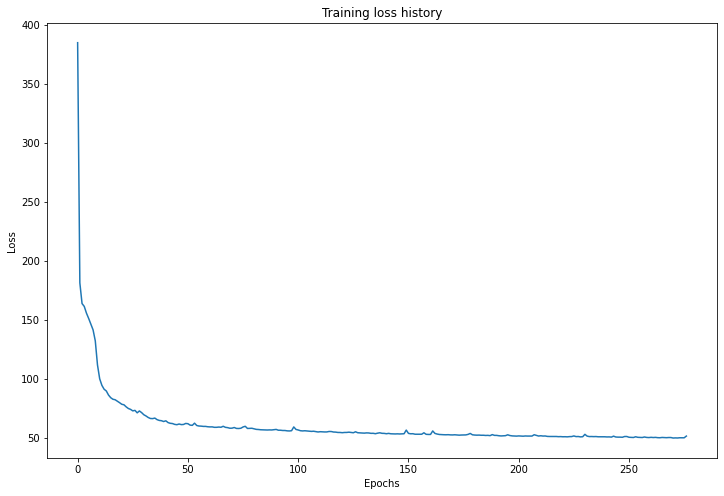

In [32]:
plot_history(TRAINING_LOSS)

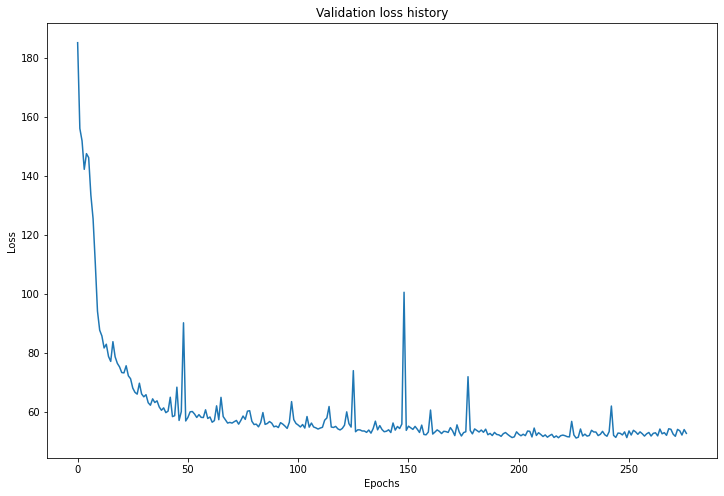

In [33]:
plot_history(VALIDATION_LOSS, False)

# Generating images using samples from normal distribution in the latent space of 512

In [34]:
# loading the best model from checkpoint
best_model = VAE()
best_model.load_state_dict(torch.load('best_model2.pt'))
best_model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyRe

In [35]:
def generate_images_sampled_from_vae(model, device, latent_size, num_images=50):

    with torch.no_grad():

        rand_features = torch.randn(num_images, latent_size).to(device)
        new_images = model.decoder(rand_features)
        image_height = new_images.shape[2]
        image_width = new_images.shape[3]

        fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(20, 10))
        decoded_images = new_images[:num_images]

        for i, img in enumerate(decoded_images):
            curr_img = img.detach().to(torch.device('cpu'))
            axes[i//10, i%10].imshow(curr_img.view((image_height, image_width)), cmap='gray')
        plt.savefig(f"faces/generated_faces.png")

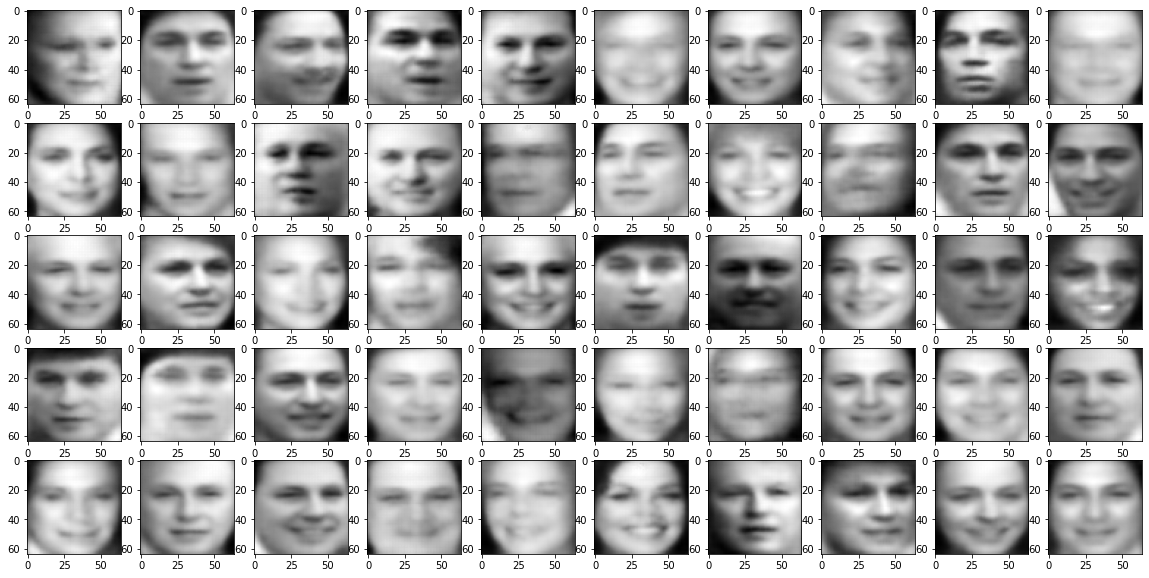

In [37]:
# images using model from the last epoch
generate_images_sampled_from_vae(model, device, 512)

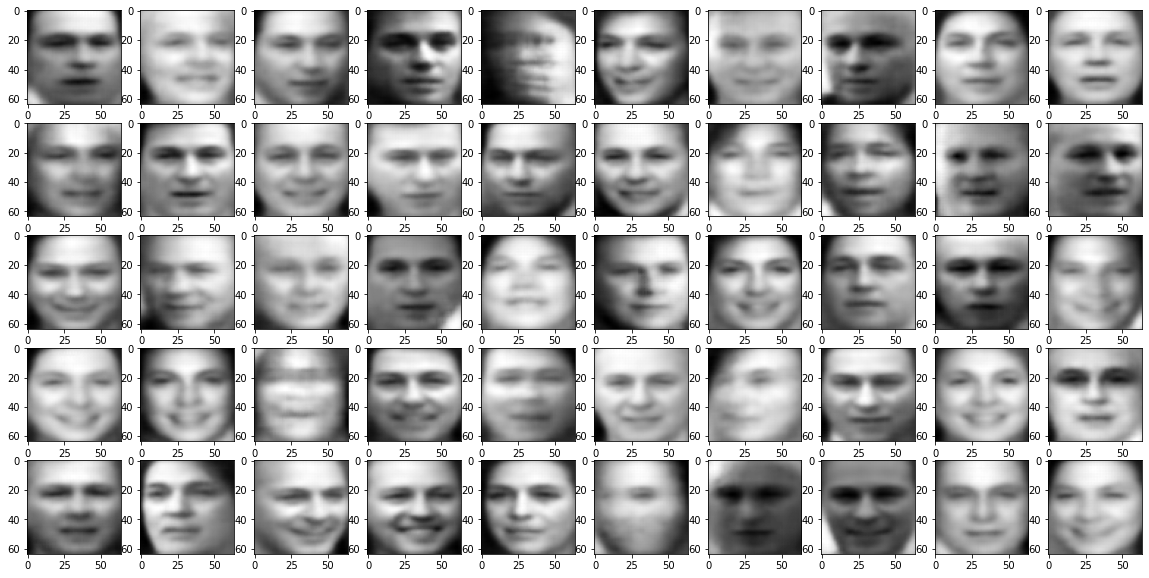

In [41]:
# images using model with the lowest validation loss
generate_images_sampled_from_vae(best_model, 'cpu', 512)